# Limitazioni Pandas e Ottimizzazioni

L'obiettivo di questo Notebook è dimostrare che le performance di Pandas degradano con dataset da 10M+. Le strategie di ottimizzazioni possono migliorare le performance ma, come vedremo, sono comunque limitate.  

**Dataset**: 
- Source: `data/sample/`
- Transactions: 20M records (~2.3 GB)

# Setup

Nella seguente cella di codice verranno importate tutte le librerie necessarie e definite alcune funzioni ausiliarie per misurare le performance di Pandas.

In [1]:
# IMPORTS

# Standard library imports
import pandas as pd
import numpy as np
import time
import os
import gc
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Memory profiling
import psutil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Pandas configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# HELPER FUNCTIONS

def get_memory_usage():
    """Get current process memory usage in MB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def measure_performance(func, *args, **kwargs):
    """Measure execution time and memory usage of a function"""
    gc.collect()  # Force garbage collection
    time.sleep(5)
    
    mem_before = get_memory_usage()
    start_time = time.time()
    
    result = func(*args, **kwargs)
    
    elapsed_time = time.time() - start_time
    mem_after = get_memory_usage()
    mem_used = mem_after - mem_before
    
    return result, elapsed_time, mem_used

def format_bytes(bytes_value):
    """Format bytes to human-readable string"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if bytes_value < 1024.0:
            return f"{bytes_value:.2f} {unit}"
        bytes_value /= 1024.0
    return f"{bytes_value:.2f} TB"

print("Helper functions defined!")

Helper functions defined!


In [3]:
# PATHS CONFIGURATION

# Data paths
DATA_DIR = Path("../data/sample/")
RESULTS_DIR = Path("../docs/results")
GRAPH_DIR = Path("../docs/graphs")   

# File paths
TRANSACTIONS_FILE = DATA_DIR / "transactions.csv"
CUSTOMERS_FILE = DATA_DIR / "customers.csv"
PRODUCTS_FILE = DATA_DIR / "products.csv"

# Verify files exist
print("Checking data files...")
for file_path in [TRANSACTIONS_FILE, CUSTOMERS_FILE, PRODUCTS_FILE]:
    if file_path.exists():
        size = file_path.stat().st_size
        print(f"  {file_path.name}: {format_bytes(size)}")
    else:
        print(f"  {file_path.name}: NOT FOUND")

Checking data files...
  transactions.csv: 2.27 GB
  customers.csv: 3.11 MB
  products.csv: 88.90 KB


# Naive Loading - Il Problema

Nella seguente cella di codice verrà caricato il dataset. Osserveremo:

- Espansione della memoria (CSV vs DataFrame)
- Il tempo di caricamento
- L'uso di memoria per ogni colonna

NAIVE LOADING - THE PROBLEM

Baseline memory usage: 197.70 MB

Loading 20M transactions with Pandas (naive approach)...
  Loaded in 32.06 seconds

Memory Usage:
  Before loading: 197.70 MB
  After loading:  5626.80 MB
  Memory used:    5429.10 MB (5.30 GB)

File vs Memory:
  CSV file size:     2328.28 MB
  DataFrame memory:  10169.62 MB
  Expansion factor:  4.37x

DATAFRAME INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   transaction_id         object 
 1   customer_id            object 
 2   product_id             object 
 3   quantity               int64  
 4   unit_price             float64
 5   total_amount           float64
 6   discount_pct           float64
 7   discount_amount        float64
 8   final_amount           float64
 9   shipping_cost          float64
 10  transaction_date       object 
 11  transaction_timestamp  object

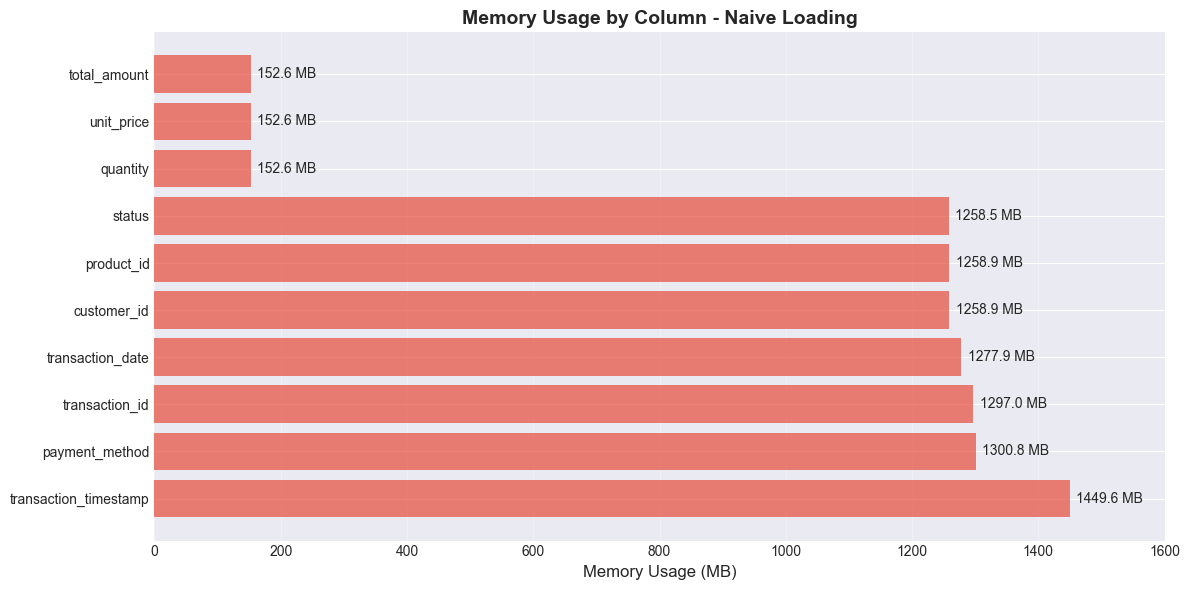


Saved: 01_naive_memory_breakdown.png


In [4]:
# NAIVE LOADING

print("="*70)
print("NAIVE LOADING - THE PROBLEM")
print("="*70)

# Baseline memory
baseline_memory = get_memory_usage()
print(f"\nBaseline memory usage: {baseline_memory:.2f} MB\n")

# Load transactions naively
print("Loading 20M transactions with Pandas (naive approach)...")

start_time = time.time()
mem_before = get_memory_usage()

df = pd.read_csv(TRANSACTIONS_FILE)

load_time = time.time() - start_time
mem_after = get_memory_usage()
mem_used = mem_after - mem_before

print(f"  Loaded in {load_time:.2f} seconds")
print(f"\nMemory Usage:")
print(f"  Before loading: {mem_before:.2f} MB")
print(f"  After loading:  {mem_after:.2f} MB")
print(f"  Memory used:    {mem_used:.2f} MB ({mem_used/1024:.2f} GB)")

# File size vs memory comparison
file_size_mb = TRANSACTIONS_FILE.stat().st_size / 1024 / 1024
data_mem = df.memory_usage(deep=True).sum() / 1024**2 # Convert in MB
expansion_factor = data_mem / file_size_mb
print(f"\nFile vs Memory:")
print(f"  CSV file size:     {file_size_mb:.2f} MB")
print(f"  DataFrame memory:  {data_mem:.2f} MB")
print(f"  Expansion factor:  {expansion_factor:.2f}x")

# DataFrame info
print("\n" + "="*70)
print("DATAFRAME INFO")
print("="*70 + "\n")

df.info(memory_usage='deep')

# Memory breakdown by column
print("\n" + "="*70)
print("MEMORY USAGE BY COLUMN")
print("="*70 + "\n")

memory_by_column = df.memory_usage(deep=True) / 1024**2  # Convert to MB
memory_sorted = memory_by_column.sort_values(ascending=False)

print("Top 10 columns by memory usage:\n")
for col, mem in memory_sorted.head(10).items():
    if col == 'Index':
        continue
    dtype = df[col].dtype
    print(f"  {col:<25} {mem:>10.2f} MB  ({dtype})")

print(f"\n  {'TOTAL':<25} {memory_sorted.sum():>10.2f} MB")

# Visualization: Memory breakdown
plt.figure(figsize=(12, 6))

top_cols = memory_by_column[memory_by_column.index != 'Index'].nlargest(10)

plt.barh(range(len(top_cols)), top_cols.values, color='#e74c3c', alpha=0.7)
plt.yticks(range(len(top_cols)), top_cols.index)
plt.xlabel('Memory Usage (MB)', fontsize=12)
plt.xlim(0, 1600)
plt.title('Memory Usage by Column - Naive Loading', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_cols.values):
    plt.text(v + 10, i, f'{v:.1f} MB', va='center')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_naive_memory_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: 01_naive_memory_breakdown.png")

## Osservazioni

Da questo primo test di caricamento otteniamo i seguenti risultati:

1. **Espansione della Memoria**: il DataFrame usa circa 4.4x la memoria del file CSV
2. **Data Types Inefficienti**: i dtypes di default (int64, float64, object) occupano molta memoria
3. **Tempo di caricamento**: circa 30 secondi per 20M di record

# Operazioni Base - Performance Baseline

Ora effettueremo alcune tipiche operazioni dell'analisi dati:
 
- Filtro
- GroupBy + Aggregazione
- Date parsing
- Aggregazione complessa multi livello

BASIC OPERATIONS - PERFORMANCE BASELINE

[1/4] Filter Operation...
  Task: Filter transactions with final_amount > 1000
    Time: 0.31s, Memory: 0.32 MB

[2/4] GroupBy Aggregation...
  Task: Aggregate by payment_method
    Time: 1.29s, Memory: 0.18 MB

  Result:
                           sum   mean    count
payment_method                                
bank_transfer    1532625086.84 382.72  4004595
cash_on_delivery 1532782484.85 383.16  4000352
credit_card      1531376210.01 383.00  3998382
debit_card       1533007760.30 383.38  3998646
paypal           1530594811.19 382.84  3998025

[3/4] Date Parsing...
    Time: 2.04s, Memory: 152.78 MB

[4/4] Complex Aggregation...
    Time: 6.32s, Memory: 172.08 MB

  Result preview:
                                 sum   count
month   payment_method                      
2024-01 bank_transfer    64655827.64  169266
        cash_on_delivery 65188320.45  170017
        credit_card      64992816.23  169202
        debit_card       65476293.39  170

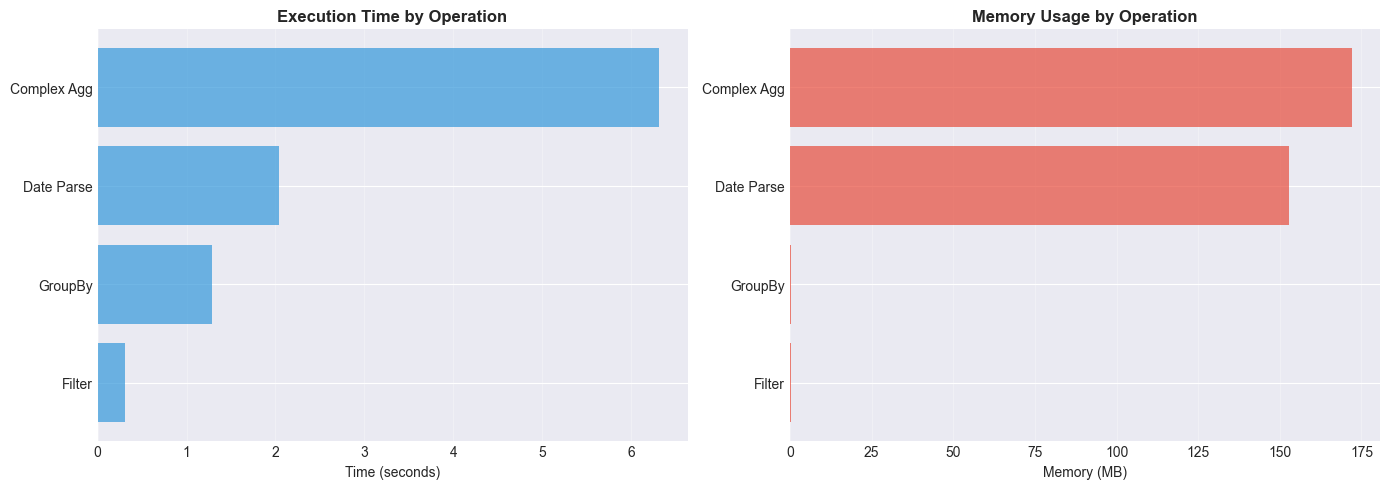

Saved: 01_baseline_performance.png


In [5]:
# BASIC OPERATIONS

print("="*70)
print("BASIC OPERATIONS - PERFORMANCE BASELINE")
print("="*70 + "\n")

performance_results = {}
# Operation 1: Filter
print("[1/4] Filter Operation...")
print("  Task: Filter transactions with final_amount > 1000")

_, time_filter, mem_filter = measure_performance(
    lambda: df[df['final_amount'] > 1000]
)

performance_results['Filter'] = {'time': time_filter, 'memory': mem_filter}
print(f"    Time: {time_filter:.2f}s, Memory: {mem_filter:.2f} MB\n")
# Operation 2: GroupBy
print("[2/4] GroupBy Aggregation...")
print("  Task: Aggregate by payment_method")

def groupby_op():
    return df.groupby('payment_method')['final_amount'].agg(['sum', 'mean', 'count'])

result_gb, time_gb, mem_gb = measure_performance(groupby_op)
performance_results['GroupBy'] = {'time': time_gb, 'memory': mem_gb}

print(f"    Time: {time_gb:.2f}s, Memory: {mem_gb:.2f} MB")
print("\n  Result:")
print(result_gb)
print()
# Operation 3: Date parsing
print("[3/4] Date Parsing...")
_, time_date, mem_date = measure_performance(
    lambda: pd.to_datetime(df['transaction_date'])
)
performance_results['Date Parse'] = {'time': time_date, 'memory': mem_date}
print(f"    Time: {time_date:.2f}s, Memory: {mem_date:.2f} MB\n")
# Operation 4: Complex aggregation
print("[4/4] Complex Aggregation...")

def complex_agg():
    df_temp = df.copy()
    df_temp['month'] = pd.to_datetime(df_temp['transaction_date']).dt.to_period('M')
    return df_temp.groupby(['month', 'payment_method'])['final_amount'].agg(['sum', 'count'])

result_cx, time_cx, mem_cx = measure_performance(complex_agg)
performance_results['Complex Agg'] = {'time': time_cx, 'memory': mem_cx}

print(f"    Time: {time_cx:.2f}s, Memory: {mem_cx:.2f} MB")
print("\n  Result preview:")
print(result_cx.head(10))

# Performance summary
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70 + "\n")

perf_df = pd.DataFrame(performance_results).T
perf_df.columns = ['Time (s)', 'Memory (MB)']
print(perf_df.round(2))
print(f"\nTotal time: {perf_df['Time (s)'].sum():.2f}s")

perf_df.to_csv(RESULTS_DIR / '01_baseline_performance.csv')
print("\nSaved: 01_baseline_performance.csv")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.barh(perf_df.index, perf_df['Time (s)'], color='#3498db', alpha=0.7)
ax1.set_xlabel('Time (seconds)')
ax1.set_title('Execution Time by Operation', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(perf_df.index, perf_df['Memory (MB)'], color='#e74c3c', alpha=0.7)
ax2.set_xlabel('Memory (MB)')
ax2.set_title('Memory Usage by Operation', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_baseline_performance.png', dpi=300)
plt.show()

print("Saved: 01_baseline_performance.png")

# Ottimizzazione Dtype

Eseguiremo le seguenti operazioni per ottimizzare l'uso della memoria:
- Conversione in `category` delle colonne categoriche con bassa cardinalità
- Downcast int64 in int32 
- Downcast float64 in float32

DTYPE OPTIMIZATION

Original memory: 10169.62 MB

Optimizing categorical columns...

payment_method:
  Unique values: 5
  Before: 1300.83 MB (object)
  After:  19.07 MB (category)
  Reduction: 98.5%

status:
  Unique values: 3
  Before: 1258.47 MB (object)
  After:  19.07 MB (category)
  Reduction: 98.5%

Optimizing integer columns...

quantity:
  Range: [1, 5]
  Before: 152.59 MB (int64)
  After:  76.29 MB (int32)
  Reduction: 50.0%

Optimizing float columns...

unit_price:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

total_amount:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

discount_pct:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

final_amount:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

shipping_cost:
  Before: 152.59 MB (float64)
  After:  76.29 MB (float32)
  Reduction: 50.0%

MEMORY OPTIMIZATION SUMMARY

Original:  10169.62 MB
Optimized: 7190.

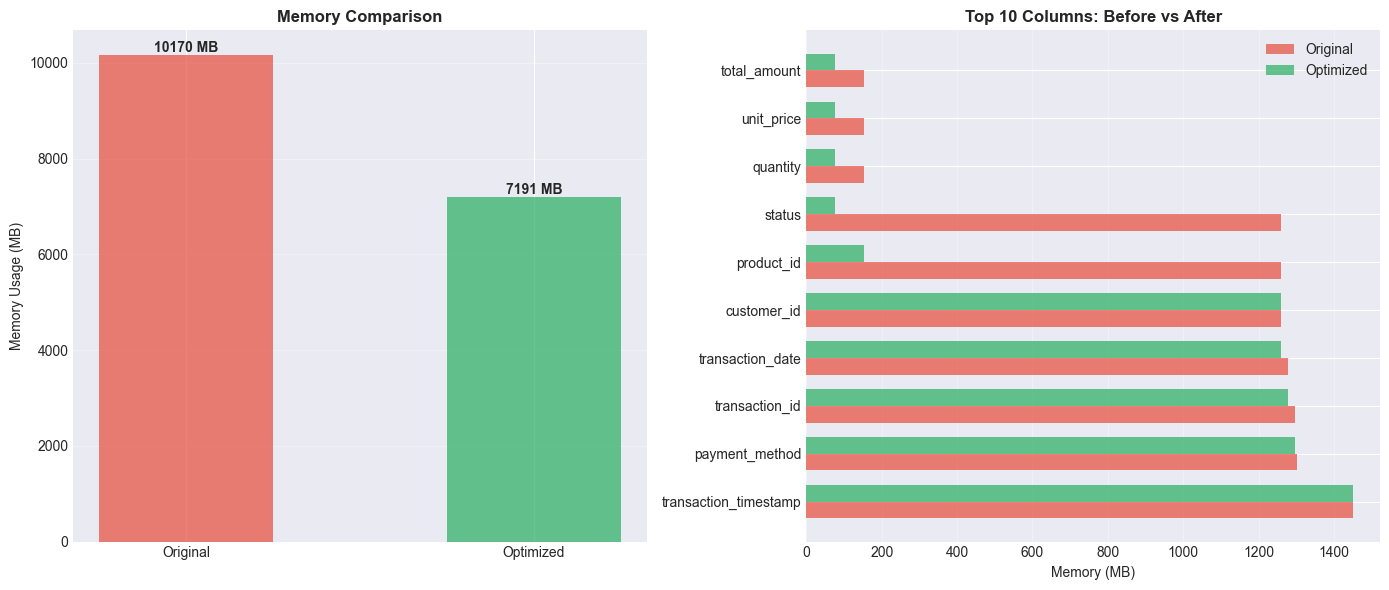


Saved: 01_dtype_optimization.png


In [6]:
# DTYPE OPTIMIZATION

print("="*70)
print("DTYPE OPTIMIZATION")
print("="*70 + "\n")

# Original memory
original_memory = df.memory_usage(deep=True).sum() / 1024**2
print(f"Original memory: {original_memory:.2f} MB\n")

# Create optimized copy
df_optimized = df.copy()

# Optimize categorical columns
print("Optimizing categorical columns...\n")

categorical_cols = ['payment_method', 'status']
for col in categorical_cols:
    mem_before = df[col].memory_usage(deep=True) / 1024**2
    
    df_optimized[col] = df_optimized[col].astype('category')
    
    mem_after = df_optimized[col].memory_usage(deep=True) / 1024**2
    reduction = ((mem_before - mem_after) / mem_before) * 100
    
    print(f"{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Before: {mem_before:.2f} MB ({df[col].dtype})")
    print(f"  After:  {mem_after:.2f} MB (category)")
    print(f"  Reduction: {reduction:.1f}%\n")

# Optimize integer columns
print("Optimizing integer columns...\n")

# Check if int64 can be downcast to int32
int_cols = ['quantity']
for col in int_cols:
    if col in df.columns:
        col_min, col_max = df[col].min(), df[col].max()
        
        # Check if fits in int32
        if col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
            mem_before = df[col].memory_usage() / 1024**2
            
            df_optimized[col] = df_optimized[col].astype('int32')
            
            mem_after = df_optimized[col].memory_usage() / 1024**2
            reduction = ((mem_before - mem_after) / mem_before) * 100
            
            print(f"{col}:")
            print(f"  Range: [{col_min}, {col_max}]")
            print(f"  Before: {mem_before:.2f} MB (int64)")
            print(f"  After:  {mem_after:.2f} MB (int32)")
            print(f"  Reduction: {reduction:.1f}%\n")

# Optimize float columns
print("Optimizing float columns...\n")

float_cols = ['unit_price', 'total_amount', 'discount_pct', 'final_amount', 'shipping_cost']
for col in float_cols:
    if col in df.columns:
        mem_before = df[col].memory_usage() / 1024**2
        
        df_optimized[col] = df_optimized[col].astype('float32')
        
        mem_after = df_optimized[col].memory_usage() / 1024**2
        reduction = ((mem_before - mem_after) / mem_before) * 100
        
        print(f"{col}:")
        print(f"  Before: {mem_before:.2f} MB (float64)")
        print(f"  After:  {mem_after:.2f} MB (float32)")
        print(f"  Reduction: {reduction:.1f}%\n")

# Memory comparison summary
optimized_memory = df_optimized.memory_usage(deep=True).sum() / 1024**2
memory_saved = original_memory - optimized_memory
reduction_pct = (memory_saved / original_memory) * 100

print("="*70)
print("MEMORY OPTIMIZATION SUMMARY")
print("="*70 + "\n")
print(f"Original:  {original_memory:.2f} MB")
print(f"Optimized: {optimized_memory:.2f} MB")
print(f"Saved:     {memory_saved:.2f} MB ({reduction_pct:.1f}% reduction)")

# Visualization: Memory comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart comparison
ax1 = axes[0]
categories = ['Original', 'Optimized']
memory_values = [original_memory, optimized_memory]
colors = ['#e74c3c', '#27ae60']

bars = ax1.bar(categories, memory_values, color=colors, alpha=0.7, width=0.5)
ax1.set_ylabel('Memory Usage (MB)')
ax1.set_title('Memory Comparison', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, memory_values):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{value:.0f} MB',
        ha='center', va='bottom', fontweight='bold')

# Column-wise comparison (top 10)
ax2 = axes[1]
original_cols = df.memory_usage(deep=True)[1:].nlargest(10) / 1024**2
optimized_cols = df_optimized.memory_usage(deep=True)[1:].nlargest(10) / 1024**2

x = np.arange(len(original_cols))
width = 0.35

ax2.barh(x - width/2, original_cols.values, width, label='Original', color='#e74c3c', alpha=0.7)
ax2.barh(x + width/2, optimized_cols.values, width, label='Optimized', color='#27ae60', alpha=0.7)

ax2.set_yticks(x)
ax2.set_yticklabels(original_cols.index)
ax2.set_xlabel('Memory (MB)')
ax2.set_title('Top 10 Columns: Before vs After', fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_dtype_optimization.png', dpi=300)
plt.show()

print("\nSaved: 01_dtype_optimization.png")

# Clean up
del df, df_optimized
gc.collect()
time.sleep(5)

# Chunking

Il chunking è una strategia che ci consente di analizzare dataset che occuperebbero più spazio della memoria disponibile, caricando ed elaborando il dataset in blocchi (chunk) e infine combinando i risultati parziali di ogni blocco. Tale approccio è utile per controllare l'uso della memoria evitanto problemi di OOM ma, d'altra parte, ha grosse limitazioni:

- Tempi di elaborazione più lenti
- Non è possibile eseguire operazioni che richiedono tutto il dataset (sort, merge)

CHUNKING STRATEGY

Processing 20M records in chunks of 1,000,000...
Example 1: Chunked Aggregation

Chunk 1: 1,000,000 records in 0.086s
Chunk 2: 1,000,000 records in 0.085s
Chunk 3: 1,000,000 records in 0.084s
Chunk 4: 1,000,000 records in 0.084s
Chunk 5: 1,000,000 records in 0.085s
Chunk 6: 1,000,000 records in 0.086s
Chunk 7: 1,000,000 records in 0.088s
Chunk 8: 1,000,000 records in 0.082s
Chunk 9: 1,000,000 records in 0.083s
Chunk 10: 1,000,000 records in 0.083s
Chunk 11: 1,000,000 records in 0.083s
Chunk 12: 1,000,000 records in 0.083s
Chunk 13: 1,000,000 records in 0.083s
Chunk 14: 1,000,000 records in 0.083s
Chunk 15: 1,000,000 records in 0.081s
Chunk 16: 1,000,000 records in 0.082s
Chunk 17: 1,000,000 records in 0.082s
Chunk 18: 1,000,000 records in 0.085s
Chunk 19: 1,000,000 records in 0.083s
Chunk 20: 1,000,000 records in 0.082s

Processed 20 chunks

Combining chunk results...

Final aggregation by payment method:
                           sum    count   mean
payment_method 

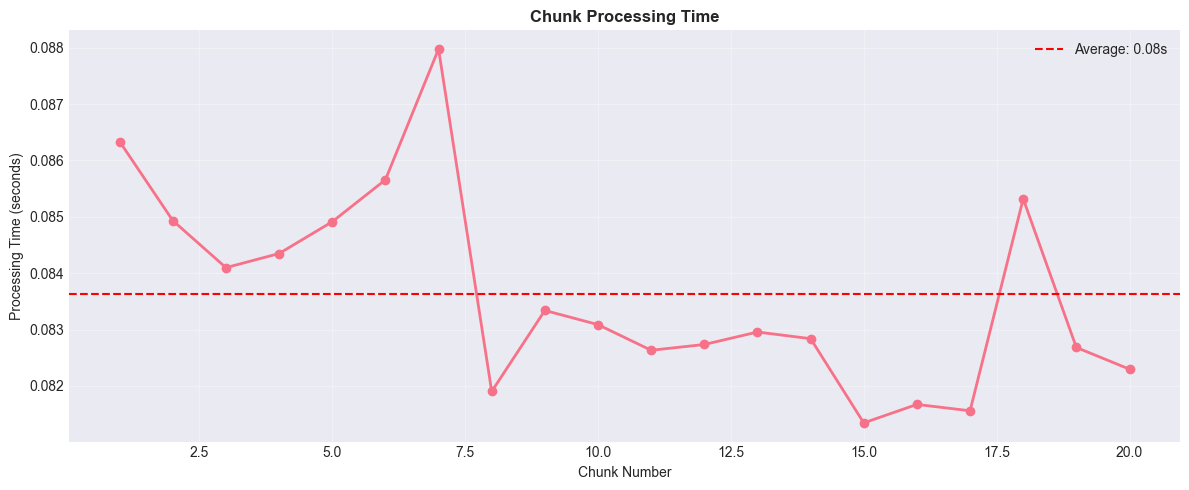


Saved: 01_chunk_performance.png


In [7]:
# CHUNKING STRATEGY

print("="*70)
print("CHUNKING STRATEGY")
print("="*70 + "\n")

CHUNK_SIZE = 1_000_000  # 1M records per chunk

print(f"Processing 20M records in chunks of {CHUNK_SIZE:,}...")

# Example 1: Aggregate by payment method using chunks
print("Example 1: Chunked Aggregation\n")

chunk_results = []
chunk_times = []
chunk_count = 0

for chunk in pd.read_csv(TRANSACTIONS_FILE, chunksize=CHUNK_SIZE):
    chunk_count += 1
    start = time.time()
    
    # Optimize dtypes on chunk
    chunk['payment_method'] = chunk['payment_method'].astype('category')
    chunk['status'] = chunk['status'].astype('category')
    
    # Aggregate
    result = chunk.groupby('payment_method', observed=True)['final_amount'].agg(['sum', 'count'])
    chunk_results.append(result)
    
    elapsed = time.time() - start
    chunk_times.append(elapsed)
    
    print(f"Chunk {chunk_count}: {len(chunk):,} records in {elapsed:.3f}s")

print(f"\nProcessed {chunk_count} chunks")

# Combine chunk results
print("\nCombining chunk results...")
final_result = pd.concat(chunk_results).groupby(level=0, observed=True).agg({
    'sum': 'sum',
    'count': 'sum'
})
final_result['mean'] = final_result['sum'] / final_result['count']

print("\nFinal aggregation by payment method:")
print(final_result)

# Example 2: Filtered loading with chunks
print("\n" + "="*70)
print("Example 2: Filtered Chunked Loading")
print("="*70 + "\n")

print("Loading only high-value transactions (final_amount > 1000)...\n")

filtered_chunks = []
total_filtered = 0

for i, chunk in enumerate(pd.read_csv(TRANSACTIONS_FILE, chunksize=CHUNK_SIZE), 1):
    # Apply filter
    filtered = chunk[chunk['final_amount'] > 1000]
    filtered_chunks.append(filtered)
    total_filtered += len(filtered)
    
    if i % 5 == 0:
        print(f"Processed {i * CHUNK_SIZE:,} records, found {total_filtered:,} matching")

# Combine
filtered_df = pd.concat(filtered_chunks, ignore_index=True)

print(f"\nFinal result:")
print(f"  Total records processed: {20_000_000:,}")
print(f"  Matching records: {len(filtered_df):,}")
print(f"  Percentage: {(len(filtered_df) / 20_000_000) * 100:.2f}%")

# Visualization: Chunk processing time
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(chunk_times) + 1), chunk_times, marker='o', linewidth=2, markersize=6)
plt.axhline(np.mean(chunk_times), color='r', linestyle='--', label=f'Average: {np.mean(chunk_times):.2f}s')
plt.xlabel('Chunk Number')
plt.ylabel('Processing Time (seconds)')
plt.title('Chunk Processing Time', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_chunk_performance.png', dpi=300)
plt.show()

print("\nSaved: 01_chunk_performance.png")

# Caricamento Selettivo

Tramite il parametro `usecols` è possibile caricare solo le colenne che effettivamento sono utili all'elaborazione. Ciò consente un notevole risparmio in termini di tempo di caricamento e memoria usata.

SELECTIVE COLUMN LOADING

Loading only 5 columns instead of all...

Comparison: Full vs Selective Loading

Full dataset:
  Columns: 14
  Load time: 30.96s
  Memory: 5087.04 MB

Selective loading:
  Columns: 5
  Load time: 18.12s
  Memory: 1786.43 MB

Savings:
  Time: 12.84s (41.5% faster)
  Memory: 3300.61 MB (64.9% less)


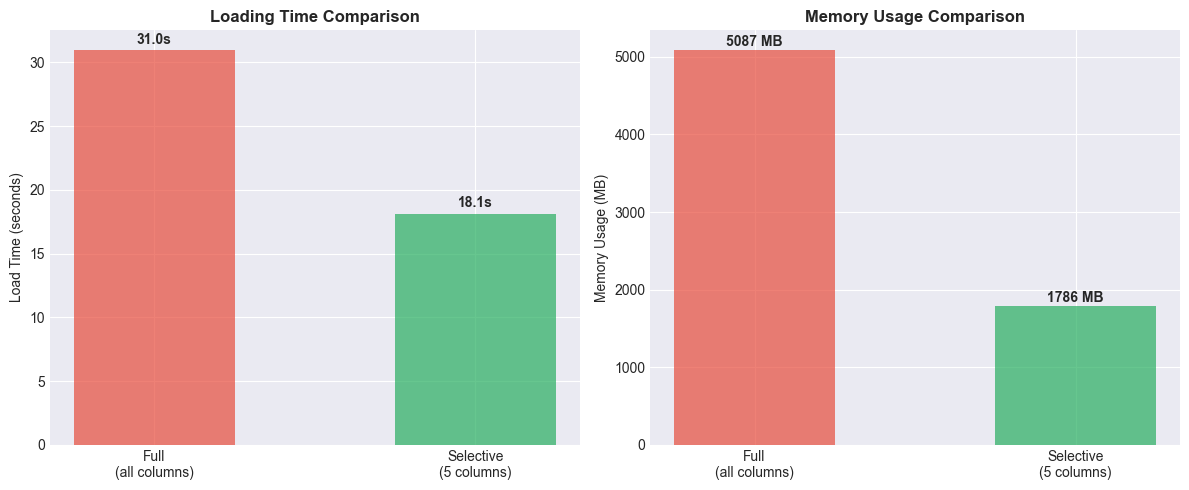


Saved: 01_selective_loading.png


In [8]:
# SELECTIVE COLUMN STRATEGY

print("="*70)
print("SELECTIVE COLUMN LOADING")
print("="*70 + "\n")

# Define columns we actually need for analysis
needed_cols = [
    'transaction_id',
    'final_amount',
    'payment_method',
    'transaction_date',
    'status'
]

print(f"Loading only {len(needed_cols)} columns instead of all...")

# Compare full vs selective loading
print("\nComparison: Full vs Selective Loading\n")

# Full dataset
mem_start = get_memory_usage()
start = time.time()
df_full = pd.read_csv(TRANSACTIONS_FILE)
time_full = time.time() - start
mem_full = get_memory_usage() - mem_start

print(f"Full dataset:")
print(f"  Columns: {len(df_full.columns)}")
print(f"  Load time: {time_full:.2f}s")
print(f"  Memory: {mem_full:.2f} MB")

# Clean up
del df_full
gc.collect()
time.sleep(5)


# Selective loading
mem_start = get_memory_usage()
start = time.time()
df_selective = pd.read_csv(TRANSACTIONS_FILE, usecols=needed_cols)
time_selective = time.time() - start
mem_selective = get_memory_usage() - mem_start

print(f"\nSelective loading:")
print(f"  Columns: {len(df_selective.columns)}")
print(f"  Load time: {time_selective:.2f}s")
print(f"  Memory: {mem_selective:.2f} MB")

# Savings
time_saved = time_full - time_selective
mem_saved = mem_full - mem_selective

print(f"\nSavings:")
print(f"  Time: {time_saved:.2f}s ({(time_saved/time_full)*100:.1f}% faster)")
print(f"  Memory: {mem_saved:.2f} MB ({(mem_saved/mem_full)*100:.1f}% less)")

# Clean up
del df_selective
gc.collect()
time.sleep(10)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
categories = ['Full\n(all columns)', 'Selective\n(5 columns)']
times = [time_full, time_selective]
colors = ['#e74c3c', '#27ae60']

ax1.bar(categories, times, color=colors, alpha=0.7, width=0.5)
ax1.set_ylabel('Load Time (seconds)')
ax1.set_title('Loading Time Comparison', fontweight='bold')

for i, v in enumerate(times):
    ax1.text(i, v + 0.5, f'{v:.1f}s', ha='center', fontweight='bold')

# Memory comparison
memories = [mem_full, mem_selective]

ax2.bar(categories, memories, color=colors, alpha=0.7, width=0.5)
ax2.set_ylabel('Memory Usage (MB)')
ax2.set_title('Memory Usage Comparison', fontweight='bold')

for i, v in enumerate(memories):
    ax2.text(i, v + 50, f'{v:.0f} MB', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '01_selective_loading.png', dpi=300)
plt.show()

print("\nSaved: 01_selective_loading.png")

# Conclusioni

I test eseguiti in questo Notebook hanno mostrato che Pandas si comporta piuttosto bene anche con dataset da 20M di records, tale limite potrebbe essere facilmente superato tramite chunking con le già accennate limitazioni. Ciò è dovuto alla semplicità dei test eseguiti: filtraggi e raggruppamenti non richiedono un uso intensivo di memoria. Operazioni più onerose, come ad esempio il merge, hanno bisogno di tanta memoria: lo stesso dataset limitato a 10M di records causa OOM con conseguente crash del sistema limitando l'uso di Pandas in casi realistici.    